# NEMA IEC Body Image Quality Phantom Analysis

In this notebook, we will go through the steps of comparing the measured and simulated data obtained from the NEMA phantom. 

In the image-space, we will calculate the

- Recovery coefficients for each sphere
- Coefficient of variation

In [1]:
import numpy as np
import os
from earl_nema import NemaRC
from analysis_fns import plot_img, plot_RCs, avg_perc_diff

%matplotlib notebook

Let's first load the measured image

<IPython.core.display.Javascript object>


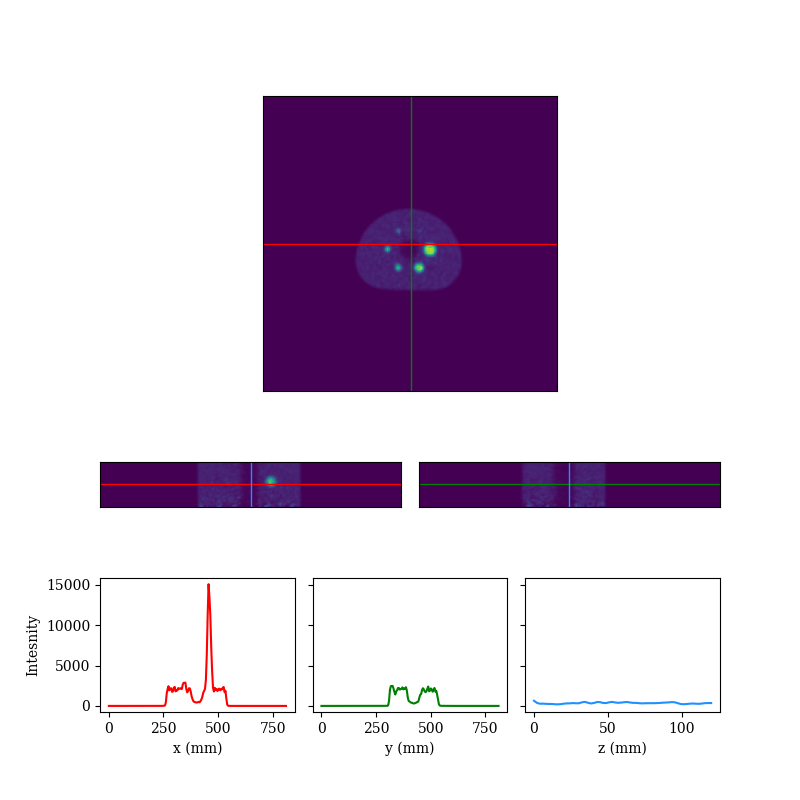

In [2]:
image_fn = '../patients/nema_meas/pet_image_000_000.v'

pet_scan = np.fromfile(image_fn, dtype=np.float32)
# Order: z, x, y
pet_scan = pet_scan.reshape((109,200,200))
# Flip along z 
# (this tends to line up the spheres better for the algorithm for some reason)
pet_scan = np.flip(pet_scan, 0)
# Remove some of the empty space in the z direction as well
pet_scan = pet_scan[:60]
# Flip in x to give the orientation the algorithm expects
pet_scan = np.flip(pet_scan, 2)
# Image resolution in z,y,x
resolution = np.array([2.027, 4.07283, 4.07283])

# Initial FDG activity concentration in the spheres
S0 = 21.04 # kBq/mL
# Time elapsed since the measurement of S0
t = 0 # min

plot_img(pet_scan, vmin=np.min(pet_scan), vmax=np.max(pet_scan), 
          slice_indx=(np.array(pet_scan.shape)/2).astype(int), 
         spacing=resolution,
         draw_lines=True)

The EANM class will run all of the necessary analyses on your given PET scan including the calculation of:

- $S_{true}$ - the true activity concentration (in kBq/mL) in the spheres at the time of the scan.
- $RC_{max}$ - the maximum activity concentration recovery coefficient of each sphere. This is defined as the maximum pixel value within a sphere (as measured on the reconstructed PET image) divided by the true FDG activity in the sphere.
- $RC_{mean}$ - the mean activity concentration recovery coefficient of each sphere. This is determined by creating a volume of interest (VOI) at 50% of the maximum pixel value. The mean pixel value within this VOI is divided by the true FDG activity in the sphere.
- $COV$ - the coefficient of variation of the image is determined by creating three regions of interest (ROIs) (each with an area of  900 mm$^2$) in three axial planes within the phantom of the reconstructed images. For each ROI, the image COV is determined by dividing the standard deviation by the mean pixel value within this ROI.

In order to calculate the RC's mentioned above, we need to create volumes of interest VOIs enclosing each sphere. We automate this process by utilizing the [`skimage.feature.blob_dog`](https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.blob_dog) function. This function detects "blobs" in the 3D image using the [Difference of Gaussian (DoG) method](https://en.wikipedia.org/wiki/Blob_detection#The_difference_of_Gaussians_approach). For each blob found, the method returns its coordinates and the standard deviation of the Gaussian kernel that detected the blob (which can be used to determine the radius). After locating the spheres, the calculation of $RC_{max}$ and $RC_{mean}$ is quite trivial.

Furthermore, the ROIs used to calculate the COV of the image are determined by using a fixed offset from two of the sphere centres, which makes this procedure fairly straight forward.

Currently the only parameters that can be varied are:

- `threshold` - The absolute lower bound for scale space maxima. Local maxima smaller than thresh are ignored. Reduce this to detect blobs with less intensities.
- `sigma_ratio` - The ratio between the standard deviation of Gaussian Kernels used for computing the Difference of Gaussians.

which can be tuned in order to successfully segment the 6 spheres. If doing so, only vary them in small increments (~0.05) as they can have a significant impact on the results.

In [3]:
threshold=0.15
sigma_ratio=1.5

results_scan = NemaRC('', S0, t, threshold=threshold, sigma_ratio=sigma_ratio, 
                 pet_scan=pet_scan, resolution=resolution)

Locating spheres using the Difference of Gaussian (DoG) method...
Segmenting VOI for each sphere...
Calculating coefficient of variation...
Calculating recovery coefficients for each sphere...
Procedure complete.


Print the results from the analysis on the spheres including $RC_{max}$ and $RC_{mean}$

In [4]:
results_scan.results

,"""Blob"" Radius (mm)",Z_loc (pixels),Y_loc (pixels),X_loc (pixels),S_max (kBq/mL),S_mean (kBq/mL),RC_max,RC_max EARL Compatible,RC_mean,RC_mean EARL Compatible
0,16.266213,33.0,104.0,113.0,21.852283,16.635382,1.038607,True,0.790655,True
1,16.266213,33.0,116.0,105.0,20.404438,15.398973,0.969793,True,0.731890,True
2,16.266213,34.0,116.0,91.0,18.476940,14.367424,0.878182,True,0.682862,True
3,12.199660,32.0,103.0,84.0,18.065767,13.446464,0.858639,True,0.639090,True
4,12.199660,33.0,91.0,91.0,13.898833,10.479383,0.660591,True,0.498070,True
5,8.133107,33.0,91.0,106.0,9.128421,7.338000,0.433860,True,0.348764,True


Plot the spheres found using the DoG to ensure that they are correct. If not, maybe try varying the sigma ratio slightly.

<IPython.core.display.Javascript object>


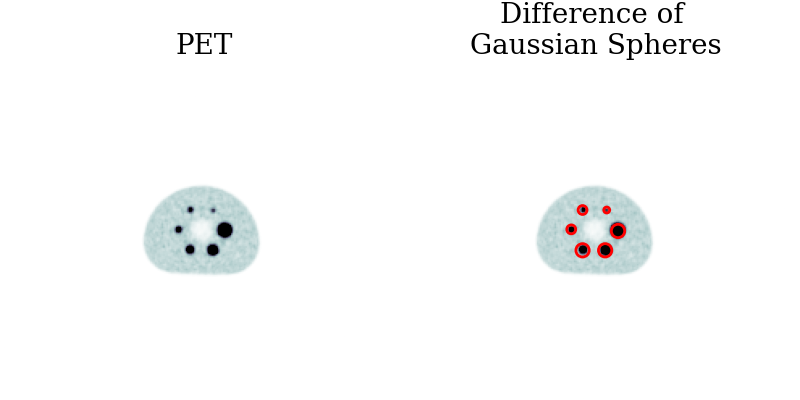

In [5]:
%matplotlib notebook
results_scan.plot_spheres()

Print the Coefficient of Variation of the image.

In [6]:
print('COV=%0.2f'%(results_scan.COV))

COV=0.12


Again, we can plot the ROIs used to calculate the COV to ensure they look ok.

<IPython.core.display.Javascript object>


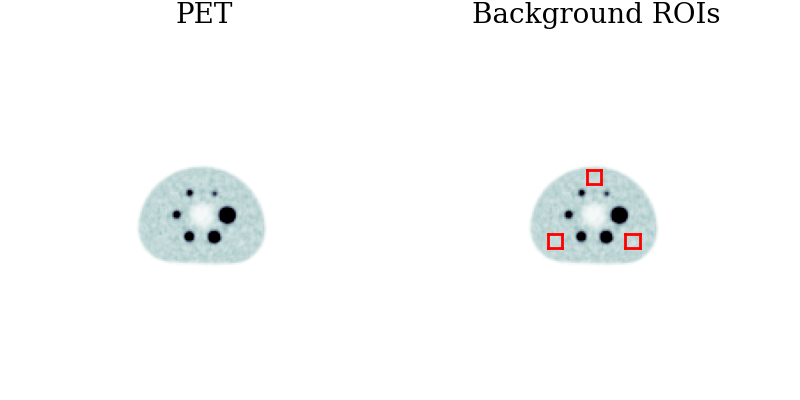

In [7]:
results_scan.plot_ROIs()

We can now perform the same analysis on the 5 simulated images and compare these to the measured image results.


Analzing ../patients/nema_simu/pet_image_1.v
Locating spheres using the Difference of Gaussian (DoG) method...
Segmenting VOI for each sphere...
Calculating coefficient of variation...
Calculating recovery coefficients for each sphere...
Procedure complete.

Analzing ../patients/nema_simu/pet_image_2.v
Locating spheres using the Difference of Gaussian (DoG) method...
Segmenting VOI for each sphere...
Calculating coefficient of variation...
Calculating recovery coefficients for each sphere...
Procedure complete.

Analzing ../patients/nema_simu/pet_image_3.v
Locating spheres using the Difference of Gaussian (DoG) method...
Segmenting VOI for each sphere...
Calculating coefficient of variation...
Calculating recovery coefficients for each sphere...
Procedure complete.

Analzing ../patients/nema_simu/pet_image_4.v
Locating spheres using the Difference of Gaussian (DoG) method...
Segmenting VOI for each sphere...
Calculating coefficient of variation...
Calculating recovery coefficients for

<IPython.core.display.Javascript object>


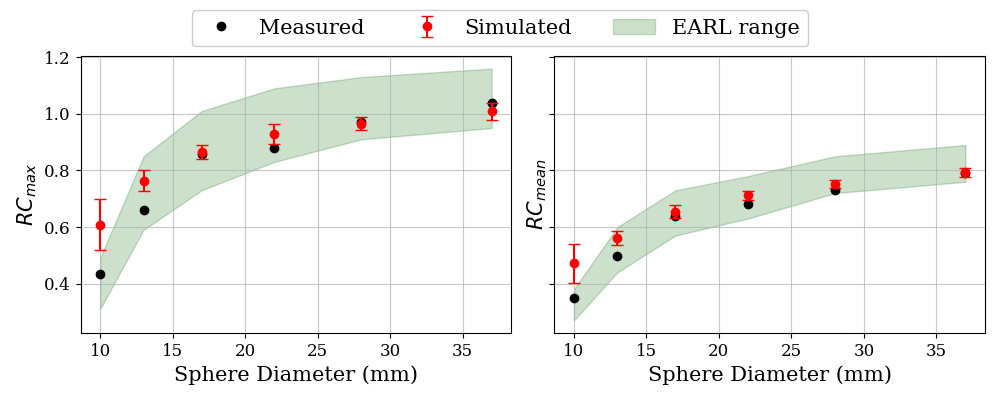

In [8]:
simu_image_fns = ['../patients/nema_simu/pet_image_1.v', 
                  '../patients/nema_simu/pet_image_2.v',
                  '../patients/nema_simu/pet_image_3.v',
                  '../patients/nema_simu/pet_image_4.v',
                  '../patients/nema_simu/pet_image_5.v']

RC_maxs_simu = []
RC_means_simu = []
COV_simus = []
for simu_image_fn in simu_image_fns:
    print('\nAnalzing %s' % simu_image_fn)
    pet_simu = np.fromfile(simu_image_fn, dtype=np.float32)
    # Order: z, x, y
    pet_simu = pet_simu.reshape((109,200,200))
    # Flip along z 
    # (this tends to line up the spheres better for the algorithm for some reason)
    pet_simu = np.flip(pet_simu, 0)
    # Remove some of the empty space in the z direction as well
    pet_simu = pet_simu[:60]
    # Flip in x to give the orientation the algorithm expects
    pet_simu = np.flip(pet_simu, 2)
    
    # Calculate the RCs
    results_simu = NemaRC('', S0, t, threshold=threshold, sigma_ratio=sigma_ratio, 
                          pet_scan=pet_simu, resolution=resolution)
    
    # Save the results
    RC_maxs_simu.append(results_simu.results['RC_max'].values)
    RC_means_simu.append(results_simu.results['RC_mean'].values)
    COV_simus.append(results_simu.COV)

RC_max_scan = results_scan.results['RC_max'].values
RC_mean_scan = results_scan.results['RC_mean'].values
    
print('\nAverage Percentage difference in RCs: %0.1f%%' % 
      (avg_perc_diff(RC_max_scan, RC_mean_scan, 
                     np.mean(RC_maxs_simu, axis=0), np.mean(RC_means_simu, axis=0))))
print('Average COV=%0.2f'%(np.mean(COV_simus)))
plot_RCs(RC_max_scan, RC_mean_scan, 
         RC_maxs_simu, 
         RC_means_simu, 
         results_scan)